# Compass Walker dynamics

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/compasswalker/actinf-compasswalker`


In [2]:
using Base64
using LinearAlgebra
using Distributions
using CairoMakie

In [3]:
# Frames per second
fps = 30;

In [4]:
function display_mp4(filename)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
    base64encode(open(read,filename)),"""" type="video/mp4"></video>"""))
end

display_mp4 (generic function with 1 method)

#### Coordinate system

In [5]:
θr = range(0, stop=2π, length=100)

f = Figure(resolution = (800, 500))
ax = Axis(f[1, 1], aspect = 1)
xlims!(-1.1,1.1)
ylims!(-1.1,1.1)

# States
θk = Observable(0.0)

# Stance leg
xr = @lift([cos(-$θk + π/2)])
yr = @lift([sin(-$θk + π/2)])
scatter!(xr, yr, linewidth=5, color=:black)

# Write animation
record(f, "animations/trig.mp4", θr; framerate = fps) do θ
    θk[] = θ
end

display_mp4("animations/trig.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAM7dtZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xNiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0+ZYiEADf//veBvzLLXyK6yXH5530srM885DxyXs1+HgxQ4gY4IPj10/4jHrGCmU3mpqKGyVfSZsfjJAAAAwAABuAVQ9ijnCp8lLLh1/jbaOKo5QFZKJQaRzHtvxu4Gg6XbAwYcLXFXmbxM6R+//IFehYWwu9lIYKsB52gMiXCEf/dLVn9J2JRPRMQ76zh29W/SjXpy1ceVnC45epub3bn+RIql8uq8IUQvVAvC9vtTnpftuNEXMyxNKs00PwgB3Bd3nWD9xMiocc1jxRRsu5r3UzsvtRp/aRnTawAbuVDrmvjIcVcNf6MN5q9A5nmDDsYb/yt4vvix3pGhIMstP/qWwq/EC4v+UXLIUwG+rk/ZuRm78aI+yNX2NS0gsP5weBj0LIZIsScfxp7dMRDv/q7DDaJALStDDZc0s3e+68qUhm7IpK2noJBfDkTcwtlK6ZyNi9ej7sBMbKanr8NqDJ8aN3vAyvx58GddibcRDIejZI0HKvjC1uKpCEALhQdXqfn9/fATFtH+rXFBb4xOBh633f+/U6hrIrcjB5v3UoqcN9a/5Kt1SYFLwev5fmHPHMArJnahHVme+vAGzdnH5Dii2j8qylqaB5+FtKCHB0mHn2E+DWW0CTEabpQJUbj896zfNExezvX63SPdf8fWl1VWaJD0Amv2YT7lhTRaNBQN9EnqTxooXntoj5lBXgyvLneX/w3RAkcGqLE2dcNQkD/ZXR5YUUnYNsMEiiPecTFk1rTmQL/9YL0j1xnz9CXl2wzagbkkU47Vmovp28vuwAawwIAc86HsvRC+W+FeDq6Z2uOVeBgkQGgB+iRzA6ATxm0AAADAAADACHtkde7CydUP0JonxcAterNO7eKueKOu1M0tVMq2OjcOUof5d2bYzGCxp1n39Ed5h+A/x05rkRgfdAhGVleOiuIwvfEA2juGThxqJ3PPhqa5ajuE8ColQ4Uvkmps2FSERsbuDecRM2eoc9gTdmaG3DN/rNHm6JsI/s2z7604ufF04PTY7X1gk+LvhRMc6RltDtnRZyjXqwFD2OMR7XhnAjAA1dRmCGINE707PnaZeVFo8uNwPvnRtf0jTkzznl7HMsvpV+O9xoKCokpNjjKf2hSfFtATkry7fZm0oubh6m/2OkHab/5KkqPFUKeIgvSGlkeUYZXXNH++7Ch8QqHBCf+HoNWEt9nyaaLPTsGIKJN7L1pNJmc733DKNunaAcLDBWW0E07DEgk2//MEvzWJM/kj0V6j7XiyDGtjIrnvjSH6gz7oHxKpls2bATeOQbyRUn5wRaI5H2CDnpLdwHU+8CBBBudTgaBYRIBPEOvctmGAAb8YAAAAwAAAwAAAwAAAwAAcgzxNmv/3QUSUM3VK50wfbdk0kf9mOkg4OooViVsyxASBl0N0qIRBaz/kb3KJZwRt1f7Bd8qRDHLJ4H/ZnfNjRuaX161S9lCaiZdEGPSwGqDEyY1/XVTsJiJfxJ0+xDw9b2XNi47i7YKyokIlapOZNGwEy9UQTbeRgrJq5/ztf5Gs6p4I/+DSxHVqfIwA+EI2CFiNW7a4+EegJOu/Fqq6mz4NVz6ABUwCoKO8RRWMHHP65USbg2+SE0qJovioiFXKJk7PW5rfH2TEe5k+ZNOIPJvNci53iZpxdWS+2bEGHA/C3vfg2fznqhK9zE+u3kuIidFiGr3ry4o8bU8mUD1D7zR/feT5AAFcAv4KQDZest+OncIvlhpCIcd3+RHD9IigoLQ8FNwSiLGO3801K5iKrWrG9EhIN6nEP2Xb0A1kRUcZyofc9om6R100r0okctlFZdhhSMe2EfAVW/2/qRsT2VBIoAQmv4WHJzF62AAAAMAAAMAAAMAAAMAAHnnHXo0cC3CGFCxwB7OnNDy7jGHPn+MyJYQ0taPZj+GmvemYJtYhvlujquaCpfZ4PV138IMY9bP5A8NImljcDf2EHMUKTOM9xF7UYKLlXge/hZMgGaUiZ3PnmXvYAAEA9+O+ewRt1/Yxx7t9Fv7pqWxvxKXQsYiEruWztUPZTrZljTgv2eLvzvlFJ1a8kD2/hkG+q53r8P14YH7zVaRE4wesDaFf3e9TGawKyzHO2kvNqDlO5CZBO9DOjDuAv5wFChh++QkPNhhqmyDevtcrTiVFxA9l2ackgDfNc4cHPFtFr5knhepdJ4C/G7tEvq1jFUZ07n4CBzZjZ8VvKdGZ//NsFSqVnV/boVAswiYvZVH8ELrexxIqili5KUf9X+4dHrhvmFaha5RVlxuAlqhD/bHP0i2rmv3WgOvYm1g3f7rLkb1Wc612euOjyst3ixwfBu+JFiyFoBEupdTzwALQAAAAwAAAwAAAwAAAwH5mQyobHvP1C8BqrjiQP+LPcy/A1kSB09m+4AA5o1MLPpResZgXvBjaXRsQJAgvxWwU5P2Oj7c6EM+j0hxuSJQN2gBj6LsFeOaRMPjfhq7Fmhdw412HeUn7vop4nkQbKxOFEt6ct5nyutiu4JNog0xl2g0d4W9BpQ0JZy7bWwJlmsiJneJyeD8Ke3znjilrG+DRih0miRm98TdIqpwFBpf9L9SJomFNPO7VUsyfzKprut95U7s+z3RaeTNiESMFTIyJF/1okfcLPt3EV9X7v+zf+Ma120Ezh2VLB6zWQt5xxeNhvIP9rdTXkbeNwe1RQ88ftMbL5XCEUNEkPpjr/lF+tjCVCO65W7ELj8m3xrvZfZ6G8QK6sd4/W6R6CxQU4PnsV0+AAC0aJb5ONewhtoH3LHZWaGR2oGlX3tqgp4svO7v69GRKW5NxzywFuM3EHfbH/rCTK27EWuXeSEkpbAna0pLuKeZHVKkQDlpEAuYvZk54aVIdaM6AeaTA4RXvRKQvdm1KBeK2FoA5whxwqhGEKMHTLpE6sHJ47FaHSPAYEdgUqZJvRrEmPaH0q1ldIW+mvQH+bDL0sRa3vcIDIkUqrXtAQdbcxJAFAmz+ISAHflnZTUW61cdwaC6P6hLLNhIPJo

## System

![](figures/compass_gait.svg)

States of the robot are the angle of the stance leg, $\theta := \theta_{st}$, the angle of the swing leg, $\eta := \theta_{sw}$, and the changes in angles, $\dot{\theta}, \dot{\eta}$.

In [6]:
# Dynamical parameters
m_h = 10.0           # kg
m   = 5.0            # kg
a   = 0.5            # m
b   = 0.5            # m
l   = a + b          # m
γ   = π/8            # radians
cθ  = 10.0            # friction
cη  = 10.0            # friction
const gravity = 9.81 # m/s^2

9.81

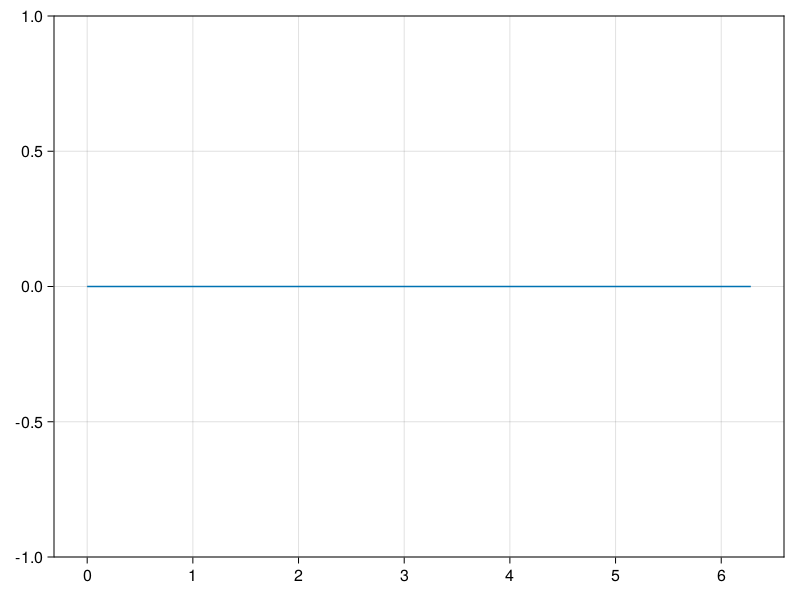

In [7]:
function u(t)
    return 0.0
     # return max(0, sin(t))
end

lines(range(0, stop=2π, step=0.01), t -> u(t))

In [8]:
function dzdt(z,t)
    
    # Unpack state
    θ, η, dθ, dη = z
    
    # Mass matrix
    M = [(m_h+m)*l^2+m*a^2    -m*l*b*cos(θ-η);
          -m*l*b*cos(θ-η)      m*b^2]
    
    # Coriolis matrix
    C = [0                     -m*l*b*sin(θ-η)*dη;
         m*l*b*sin(θ-η)*dθ                      0]
    
    # Gravity terms
    τg = [(m_h*l+m*a+m*l)*gravity*sin(θ)-cθ*dθ; -m*b*gravity*sin(η)-cη*dη]
    
    # Control matrix
    B = [-1, 1]
    
    return [dθ; dη; inv(M)*(-C*[dθ, dη] + τg + B*u(t))]
end

dzdt (generic function with 1 method)

In [9]:
function RK4(z,t,dt)

    K1 = dzdt(z,t)
    K2 = dzdt(z + K1*dt/2, t+dt/2)
    K3 = dzdt(z + K2*dt/2, t+dt/2)
    K4 = dzdt(z + K3*dt, t+dt)

    return dt*1/6*(K1 + 2*K2 + 2*K3 + K4)
end

RK4 (generic function with 1 method)

## Animation

In [75]:
function show_state(θ, η, contact)
    
    f = Figure(resolution=(800,700))
    ax = Axis(f[1, 1])

    # Slope
    poly!(ax, Point2f[(0, 0), (3, 0), (0, 3tan(γ))])
    CairoMakie.ylims!(ax, [0.,1.])
    
    # Hip joint
    hipx = contact[1] + l*cos(-θ + π/2)
    hipy = contact[2] + l*sin(-θ + π/2)

    # Stance leg
    xk_st = [contact[1], hipx]
    yk_st = [contact[2], hipy]
    
    # Swing leg
    xk_sw = [hipx, hipx + l*cos(-η + π/2)]
    yk_sw = [hipy, hipy - l*sin(-η + π/2)]
    
    # Visualize
    lines!(xk_st, yk_st, linewidth=5, color=:black)
    lines!(xk_sw, yk_sw, linewidth=5, color=:black)
    CairoMakie.scatter!([hipx], [hipy], marker=:circle, markersize=20, color=:red)
    
    # Set axis properties
    ylims!(-.2, 3.2)
    xlims!(-.2, 3.2)
    
    return f
end

show_state (generic function with 1 method)

In [11]:
function animwalker(θt::Vector{Vector{Float64}}, contact::Vector{Float64})

    f = Figure(resolution=(800,700))
    ax = Axis(f[1, 1])

    # States
    θk = Observable(0.0)
    ηk = Observable(0.0)

    # Slope
    poly!(ax, Point2f[(0, 0), (3, 0), (0, 3tan(γ))])
    CairoMakie.ylims!(ax, [0.,1.])

    # Stance leg
    xk = @lift([contact[1], contact[1] + l*cos(-$θk + π/2)])
    yk = @lift([contact[2], contact[2] + l*sin(-$θk + π/2)])
    lines!(xk, yk, linewidth=5, color=:black)
    
    # Hip joint
    hipx = @lift([contact[1] + l*cos(-$θk + π/2)])
    hipy = @lift([contact[2] + l*sin(-$θk + π/2)])
    CairoMakie.scatter!(hipx, hipy, marker=:circle, markersize=20, color=:red)
    
    # Swing leg
    xk = @lift([contact[1] + l*cos(-$θk + π/2), contact[1] + l*cos(-$θk + π/2) + l*cos(-$ηk + π/2)])
    yk = @lift([contact[2] + l*sin(-$θk + π/2), contact[2] + l*sin(-$θk + π/2) - l*sin(-$ηk + π/2)])
    lines!(xk, yk, linewidth=5, color=:red)    
    
    # Set axis properties
    ylims!(-.2, 3.2)
    xlims!(-.2, 3.2)

    # Write animation
    record(f, "animations/passive-compass-walker.mp4", θt; framerate = fps) do θ
        θk[] = θ[1]
        ηk[] = θ[2]
    end
end

animwalker (generic function with 1 method)

In [12]:
Δt = 0.01
time = range(0, stop=10.0, step=Δt)
T = length(time)

1001

In [13]:
# First contact point
contact0 = [1.5, 3tan(γ)/2]

# Preallocate
z_ = zeros(4,T)

# Initial condition
z_0 = [0.1, 0.1, 0.0, 0.0]
z_kmin1 = z_0

for (n,t) in enumerate(time)
    
    # Forward simulation
    z_[:,n] = z_kmin1 + RK4(z_kmin1, t, Δt)
    z_kmin1 = z_[:,n]
    
end

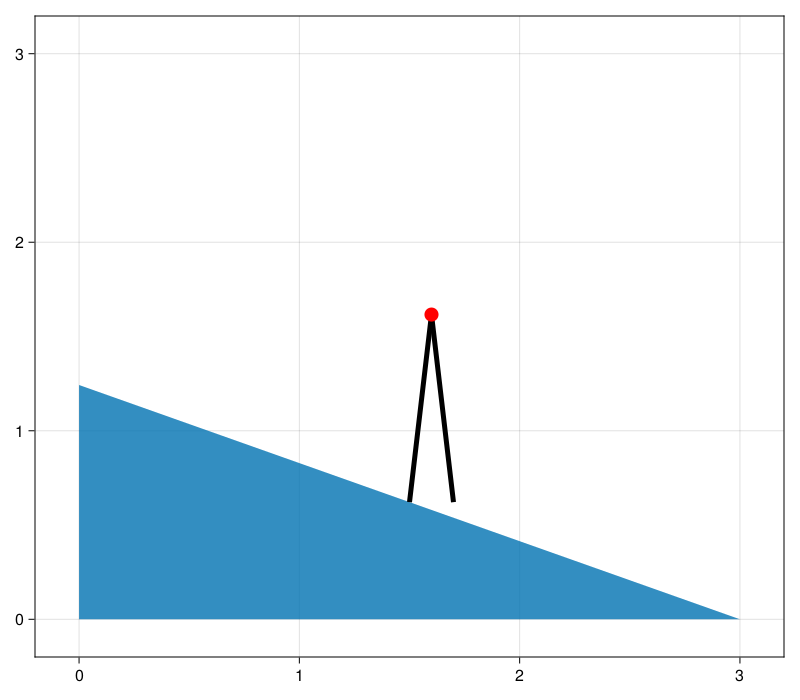

In [29]:
show_state(z_0[1], z_0[2], contact0)

In [15]:
animwalker([z_[1:2,i] for i in 1:T], contact0)

"animations/passive-compass-walker.mp4"

In [16]:
display_mp4("animations/passive-compass-walker.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAC5D1tZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABnOZYiEADf//veBvzLLXyK6xl/7hCX/gA8wGEQFmVodKDQAklP0NOAa2Zf1+rkKfwYzAGns4nhcQ4AAAAMAAAMAAAMAN23gR2h2+wbLuXKPuvX8iRmclpG6Pa3f0hJdHRvZ8K5oDRHY2TqX8NgiFcuVshqDIlXMPZ4PJO2L5664oiD0SrqOAzjJT+gHIp8sjdz0wB1MkplpxEyNHJcHZ64YqklEVReq5NiEX8/+65n0dfTwHBFBeCxCUJcgubodHkfkLN+XPkWdv+Fgwph0ORUJJy7ztCJGAbxGqpXExFmAAAXX2doXJsqisiAxniUYcDtMZa2F3EXQeVVVXBbw2yUVjf1BiHoMKyewGo6vssj7sBKXSswtS5AWVdcPENgBfTh6VkUqD1hkwMChWbCCNfJdGD2tM/wEnvfRJYfoAs+DKNMrxVG0iFzM2/f5qCkslidtVt/NsXxiJtP2VQCcwYUFiSGqJm/cktKgb8WyR4n/JcV8jCIjwF0SToT6iEq8fG4LQszm4ko6RCuYTuHE3vw7bzNP4MECSvhQp/vVhL4ACYnDHrSsiSWj3TTM8FBbVoVUnRith8D9F1r8T6Ki8teOb6FCmoJ4I4AAB60AWoBXwIIBDAJsBngUAEZCVHyxsjPJUjb+EvkKlEGcoCusg1gq/GG4GDRzd1fZeHnR8k8IY6hMeUAADQ+I2xkoGFzVjmM54t32snRAqM9xOiU7+5YvimNxXFZH/go8Pet4Ra2ZiHNnpCSH9K6nF0QZx2Ck6SnRGV0Bn9gWQlUcbGkLAW3WB0KnvA2Qq8yP7NduzkEVodSKbz2sE+C7nPgs1cuD+V1XjFcsaKMXWGiaDRUiNoPleb13ZRIwvaDXPkYKnwCQfUlUKOXY/3up9Zh9JUbd2Fpts8gsTJAU9HUOtpR0Akr51q2r0hotFZ+RwAADdgESBVqg8OCTuClgLNvIw13k0whASo/V4Z4oUndTbUAAxfzzJ/Er+EazdfofC0H17kPWLhiIXwf9Kp04Jz9yBeC3E4m03jWlMggRVhTQ4L7gMNuOp8H6WLJjWElVwHXZ3971VrA1HOR48dj+VXJxnSHheho9qR2d9eBP7HLWnCHQ3iExhUq2Isou6vEghdtIHDmzIy1rh+jFHvSm9ddaW/eoh8tpHOgN3X4CSq54b1iB2Iu/ARSu5oVhOMx62NklGM7GmJRKOP39HrsWIpAMQPOTIF1uYZaBQjGx3FmI0uWrXSsn+BQwLg8ba6XprkZHrkqms8eKciglVT8wxesIg27e4yvw2R30+r2U0g3qS0rQCG06EhTiVtQnBHf7a//J2IC8K4ge1bDwvaaMsVJZqAAH8f0F3K/akABvtGZXCVBxUAGEWN66B79X67nlq8zsb11hCmgjf4VJib6K5CpYbIbPbfOcSvIuK8Pten1MCNG01jx6DMwnjdZeSdiKNplNuNOFTVo9kJTxGn04FIhqH8Bl/y+wgfAA2L8xEcRriGeHUsALfkA7/vAL45cNgM5P98mjRfNRGUWZP73jcj6lYXCMnKEBHL0SO7hbGVINpdzhLzbTZVxBp9XHpTqme9uNv/IgPn3KLxc5AYmH4ICnpsD9iJAtKpt2ltoCEBpwQKW6jKMb74ipx/umrcqlQrxydvViK4wAJDRcUSyEHZgAIkRZk5O2UZePJh76S13kmRkbLS2N8tC+sfY6pWzRkuKNXheQcWctAO8Ze+2Kg9iUhLAQbfG0YOIPjtkRbXGeVE4z53GO1/+WmYTFqNTrG2npAjh9pJQa+809MGUUdDwDNCv1k/356LiHhx4RNJiXY/RHgQ431ELHcrF7Tzeo/FgHellJtXTrZxqzl27ipskTjXxbnaqG7iKvPtk0cI7ufKahVIKxI3qNY1OMtlXJf9ey5sp18iLZQ4Aawqbv0bA+4Gm+GOBte9iBQybKx0pyD2IuaUUDYyoxmvr4D8o30TuQuC+N7XagnAaNNNnSFY4p331cCF+ayFtvfOk49Dp9rjXhh8JtgGX8V6lulf2NF3nP1N9OK3LU3VZXqYN8AgCGBHjC+ob3fdtPv25tejXwQnLtOtvMXvFjxw5AoXwHMRfHmX700ICykkPWEn454jx0+WG9xrvwTzZNqjsyju9vesuQ2G2ipUlgWad6bstXSnS+M75h5PTkmdqCBbbGT0dAzskKegrEuAzd5oNBiNLTpGwuYinzY/LNmZAQVWLHOubzBluhsHsg0ZxOSsb395lPD1A1qq3JiWDI9nsmSbzbuFA4RPIZPyGvHOxeoyAv11sD87s4opvkHk1dN+CJED5YVrcxQmVjoupYBYK9THZRc6z8FvHWnJZyjD4FyxzgrWedRG5xsAnCuySFr2EXjS8cgIVy1cNpSVAYvcpoc7+LebaDP3pJdIvG1UwBjSfBjUKQau+7OvaLVUII2zeCE8W8AsJBoVR8An2ERjn058RwysR6tyhXLBkYeNiC6A2JDeL20Lzod3YI2E86vjr4XZcvOxZDA99muZVreTy4iX0hRTO+rnMv77tEVBYyJlRi2jXoC7/BTN0Kk+uf2pjvJdm0XSU9zePlxks6vpsrPZGQ/NV+MlOLsfjwLd9dtP1CUhrGDHt4escggr/Fm/NF9w0oNCO4APFR/T4QMQAABS4/eicdTTPHZ5r9bHHw0tSUGPmTMHJvtROb9FCXJu7bXkJjZRpDl1sisPpjGEHCF1gUbEqBVp2zFnWT5QCn7pZvMHvTPJbt3jPMFkEVwOGrKd5y2+bpezO6WSvaqT5nEfgBmbGrybgXtVKGJvCVtALmR7QbE4FI1YgcjvV5MH8ehxjCPkqta21mjxc83bmDTxrg9KuQrVIDoWonRHh/66ZQvvthtQ0lYf4YHZuk+R4pC+H/9ZbiZhSXLDZuAb3Vxv5v4HvSYlqoDYhmt7MnV8mEV7Og+LDv7vf99yD31pcKrTwIv6y+fZIIvqBeqvJGKtkTUcfP+85eDQAr33tnXkb7iUDGsWYUptskGET

## Foot collision

In [184]:
function check_collision(x,y)
    "Check distance to halfplane"
    
    # Normal vector to incline
    nv = [1.,3.]
    
    # Distance to origin
    db = -dot(nv, [0., 3tan(γ)])
    
    # Check side of halfplane
    return (dot(nv,[x,y]) + db) <= 0.0
end

check_collision (generic function with 1 method)

In [170]:
# First contact point
contact = [1.5, 3tan(γ)/2]

# Preallocate
z_ = zeros(4,T)
c_ = falses(T)

# Initial condition
z_0 = [0.1, 0.1, 0.0, 0.0]
z_kmin1 = z_0

for (n,t) in enumerate(time)
    
    # Forward simulation
    z_[:,n] = z_kmin1 + RK4(z_kmin1, t, Δt)
    z_kmin1 = z_[:,n]
    
    # Check collision
    xk = contact[1] + l*cos(-z_[1,n] + π/2) + l*cos(-z_[2,n] + π/2)
    yk = contact[2] + l*sin(-z_[1,n] + π/2) - l*sin(-z_[2,n] + π/2)
    c_[n] = check_collision(xk,yk)
    
end

In [191]:
function tmp(z1,z2)
    xk = contact[1] + l*cos(-z1 + π/2) + l*cos(-z2 + π/2)
    yk = contact[2] + l*sin(-z1 + π/2) + l*sin(-z2 + π/2)
    return xk,yk
end

tmp(z_0[1], z_0[2])

(1.6996668332936564, 2.6113286741156942)

In [198]:
tt = [tmp(z_[1,i], z_[2,i]) for i in 1:T]

1001-element Vector{Tuple{Float64, Float64}}:
 (1.6997194060844703, 2.611323397761811)
 (1.6998767154754548, 2.6113075920966726)
 (1.7001382387081707, 2.6112812570991943)
 (1.700503572399976, 2.6112443465584323)
 (1.7009724308063752, 2.6111967686092976)
 (1.7015446442373194, 2.6111383859840056)
 (1.7022201576234166, 2.611069015986434)
 (1.7029990292276869, 2.610988430194762)
 (1.7038814294982083, 2.610896353895967)
 (1.7048676400566773, 2.6107924652540815)
 (1.7059580528176046, 2.610676394212457)
 (1.707153169232515, 2.6105477211286936)
 (1.7084535996531607, 2.6104059751393316)
 ⋮
 (2.422096353619591, -1.1241008944221518)
 (2.43192504225636, -1.1189239849370338)
 (2.4414035770104014, -1.1138396025894752)
 (2.4505298442364274, -1.1088545105903695)
 (2.4593020362456794, -1.1039752461919887)
 (2.4677186410803307, -1.0992081038627999)
 (2.4757784320703315, -1.0945591198210973)
 (2.483480457280865, -1.090034057970199)
 (2.490824028953269, -1.085638397267124)
 (2.497808713035979, -1.08137732

In [199]:
f = Figure(resolution=(800,700))
ax = Axis(f[1, 1])

scatter!(time[c_], tt[c_][2], color=:red)
scatter!(time[.!c_], tt[.!c_][2], color=:blue)
f

LoadError: `Makie.convert_arguments` for the plot type Scatter{Tuple{Vector{Float64}, Tuple{Float64, Float64}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Float32}, ::Tuple{Float64, Float64}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [175]:
function animwalker(θt::Vector{Vector{Float64}}, contact::Vector{Float64})

    f = Figure(resolution=(800,700))
    ax = Axis(f[1, 1])

    # States
    θk = Observable(0.0)
    ηk = Observable(0.0)

    # Slope
    poly!(ax, Point2f[(0, 0), (3, 0), (0, 3tan(γ))])
    CairoMakie.ylims!(ax, [0.,1.])

#     # Stance leg
#     xk = @lift([contact[1], contact[1] + l*cos(-$θk + π/2)])
#     yk = @lift([contact[2], contact[2] + l*sin(-$θk + π/2)])
#     lines!(xk, yk, linewidth=5, color=:black)
    
#     # Hip joint
#     hipx = @lift([contact[1] + l*cos(-$θk + π/2)])
#     hipy = @lift([contact[2] + l*sin(-$θk + π/2)])
#     CairoMakie.scatter!(hipx, hipy, marker=:circle, markersize=20, color=:red)
    
#     # Swing leg
#     xk = @lift([contact[1] + l*cos(-$θk + π/2), contact[1] + l*cos(-$θk + π/2) + l*cos(-$ηk + π/2)])
#     yk = @lift([contact[2] + l*sin(-$θk + π/2), contact[2] + l*sin(-$θk + π/2) - l*sin(-$ηk + π/2)])
#     cl = @lift(check_collision(contact[1] + l*cos(-$θk + π/2) + l*cos(-$ηk + π/2), contact[2] + l*sin(-$θk + π/2) - l*sin(-$ηk + π/2)) ? :red : :blue)
#     lines!(xk, yk, linewidth=5, color=cl)
    
    # Swing leg
    xk = @lift(contact[1] + l*cos(-$θk + π/2) + l*cos(-$ηk + π/2))
    yk = @lift(contact[2] + l*sin(-$θk + π/2) - l*sin(-$ηk + π/2))
    cl = @lift(check_collision(contact[1] + l*cos(-$θk + π/2) + l*cos(-$ηk + π/2), contact[2] + l*sin(-$θk + π/2) - l*sin(-$ηk + π/2)) ? :red : :blue)
    scatter!(xk, yk, linewidth=5, color=cl)
    
    # Set axis properties
    ylims!(-.2, 3.2)
    xlims!(-.2, 3.2)

    # Write animation
    record(f, "animations/passive-compass-walker.mp4", θt; framerate = fps) do θ
        θk[] = θ[1]
        ηk[] = θ[2]
    end
end

animwalker (generic function with 1 method)

In [176]:
animwalker([z_[1:2,i] for i in 1:T], contact0)

"animations/passive-compass-walker.mp4"

In [177]:
display_mp4("animations/passive-compass-walker.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABax5tZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABM2ZYiEADf//veBvzLLXyK6xl/7hCX/gA8wGEQFmVodKDQAklP0NOAa2Zf1+rkKfwYzAGns4nhcQ4AAAAMAAAMAAAMAN23gR2h2+wbLuXKPuvX8iRmclpG6Pa3f0hJdHRvZ8K5oDRHY2TqX8NgiFcuVshqDIlXMPZ4PJO2L5664oiD0SrqOAzjJT+gHIp8sjdz0wB1MkplpxEyNHJcHZ64YqklEVReq5NiEX8/+65n0dfTwHBFBeCxCUJcgubodHkfkLN+XPkWdv+Fgwph0ORUJJy7ztCJGAbxGqpXExFmAAAXX2doXJsqisiAxniUYcDtMZa2F3EXQeVVVXBbw2yUVjf1BiHoMKyewGo6vssj7sBKXSswtS5AWVdcPENgBfTh6VkUqD1hkwMChWbCCNfJdGD2tM/wEnvfRJYfoAs+DKNMrxVG0iFzM2/f5qCkslidtVt/NsXxiJtP2VQCcwYUFiSGqJm/cktKgb8WyR4n/JcV8jCIjwF0SToT6iEq8fG4LQszm4ko6RCuYTuHE3vw7bzNP4MECSvhQp/vVhL4ACYnDHrSsiSWj3TTM8FBbVoVUnRith8D9F1r8T6Ki8teOb6FCmoJ4I4AAB60AWoBXwIIBDAJsBngUAEZCVHyxsjPJUjb+EvkKlEGcoCusg1gq/GG4GDRzd1fZeHnR8k8IY6hMeUAADQ+I2xkoGFzVjmM54t32snRAqM9xOiU7+5YvimNxXFZH/go8Pet4Ra2ZiHNnpCSH9K6nF0QZx2Ck6SnRGV0Bn9gWQlUcbGkLAW3WB0KnvA2Qq8yP7NduzkEVodSKbz2sE+C7nPgs1cuD+V1XjFcsaKMXWGiaDRUiNoPleb13ZRIwvaDXPkYKnwCQfUlUKOXY/3up9Zh9JUbd2Fpts8gsTJAU9HUOtpR0Akr51q2r0hotFZ+RwAADdgESBUgboAAAAwAAAwBXkamPr5brI+Nm+8QIp2TWU+HKIVDeCDqzcm3IFnt3/W9wTKo+Do1JHlc9NBx+2z35CUyFqd2Yqq4l4uiR8TYGKHfeD6sWXZYcILOhlOOS7rAKpYnrPl+7GfvlB/HqH409YATFfK2JWUxM9+jNCr8AWKpHz9IH5T4F3eBcjiK0f37vi0gYv8b80ajBsUTrhRFnqzzOsk7d0yB13MAXB2WjZsr9lPjYhNY5BcXZMjYSq4ZVuLdQpi8NjS/CLhlxAm0Klver9xecMzvXQFm+r7iUeV/uDahzOl3dURoAHL40Hx/3++bsmbge4lHbqTIaYEcPyzgm7p4zSIMZTSyDHqdt6wsRLlbiuK+/8s6Y72u6Jn3VrQN040vMdpCa6Alxc6lHWeN40mXhskavxQOYcJyaELPdrdda27/oylE9p2DBXSV5Rjh2i6rT8OKPdLX37UmxTFwyzFMD2uvDDGbkJ5D3gLOuS9DxblyqBGjvZ6K/FEatm+chx0P2oHE4HCO5tHf5hr8uAY93JP7yE/q1LRhc35Xt+DlV8DDTHD9UKIPATTUWBgAm2JHCG30I44crZLkKCFO1zcGgiInB2C5nc3FCo/IassQ+yVocc/pWE6oBaSjmycjkcRdD+LDGJnrg/fu8jaawR0RcH1tT7h/aWwFOcpdnXBvH1BjBPJx8VbyjpKKB/g6DG/E5NpOluaCD/3qXSfSqgF9fC0cIjquH/2/oM4lD9s3bxyQaIzXr8+0pWQbS85AFg3EZhBjFWQrFgZytlue5SmhCQbxEtHra+4JF4wpmD+2jnl0rroUWSsCxMD2wXU01Vybe8by2/LyU8AF5/4rVWz7coNK9Df7yQBMIHUWuQXFdTpqVBzczyAiKQ4q98ZXu1RXYI5+79h6FJE6+PAagd5PhQQFpaUtK1kkqua0Ol7xM2DeONmsPq4FZl4kl93qw23rOoYrCl7j3UK/fV5pghxB3Y5BUuWJtZvczDkPwt9yCWunRKirxhxVzwvxob9dl+NEY9zJJgKT7CMFthuieWr+VTOko3jWgQzb0oCIeG+s/tQF7nvX+IBAXKp/umZDgR/r41+9TvYV+OvYyt5hbv8ExjB8nDPFU5YhXBPDPX5ytYL1xRcHchlGoXr6FPXtoMgM4bIt3TEQY94LoGi2B8sHCyRj9wl/SoiqUowgnENQ1zMilrdEVCy/phVdw3c93YFNRSyN4Wy2wlWGZl5cDJRxx1kFJ4Dbv3k+a3l185q7Zcx529VG3rMg4lJYs3MwWl+WuBuJTs2xsNDu8G8BljswC471skgTfMqtB/lauJO50kDreFRHEbI9OnlAuVUJlgWkvhW7izfrb18Xi/tgjIw14fGabogAVyj0Mi5TzY0E2+eNsjBDB2VLJq5epWEgjpHqJ2Txt0iQz9a0PCZXcbU9hSuXoSGMFvbWdpZxHYTElFyWpXwrGtYkRDJZkZ97uzRYG+bF/bMDF3v42xahvnIsSN/iETTaYKn6I0k1iUXyQb2m3l8B2mbya/xo/0aVxrwDMNKr60XMHmeSXRnngqcCX38Hh1iYa93XurhE0Q0WXnRlv/UX12sg1PVjmZKCVGKqfGVS+XjNgSttQogEfGQ4EDXGdlRGGE10aoIiuJT8PpQZrjdBMqcGATkAAAA9eQwhkcTiWFRP+wMzlytr+clAKZmHUSXxIuSO8nSesu0K1i1/84gFw8oy+hpbXNxCASYZ+fK07CppRUchI5IsbvGUIQECarlo7FkPHo8/aEyUbFEMJ8FLAzlLrD/B7QlbT512Pamxejx3eziarTE+1hYDnzD4VJgbLlnkt0m1J+GhQiT1oBhSXNPCa3uaSs6P7/I92ssKdBHoDukMQT6ca9M5/H92Lrktwdlt1lgs7J6FOGJkPp+6iS8QbHNAtzQWE9RdhRva1HcqMUy4AAI/JgPGnpn6+TVDKKPvsPUJskZuVDKAa7lbAXH4XnquM4k5fz+JxESsc/igYpMQumhD6ZTD+RaHTxVHVrqGCyVPoNEIx9WhiWFXUu6CKzorFqezpFGnk/nx